train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [1371]:
import numpy as np
import re
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse

import warnings

warnings.filterwarnings("ignore")

In [1372]:
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test.csv")
df_rent.head()

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [1373]:
df.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [1374]:
df.isna().sum()

ID                 0
area_type          0
availability       0
location           1
size              14
society         4428
total_sqft         0
bath              65
balcony          504
price              0
dtype: int64

In [1375]:
# Encoding Availability
df['availability'] = df['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

## PRELIMINARY CLEAN-UPS

In [1376]:
df.balcony.value_counts()

2.0    4069
1.0    3894
3.0    1342
0.0     847
Name: balcony, dtype: int64

<AxesSubplot:xlabel='size', ylabel='balcony'>

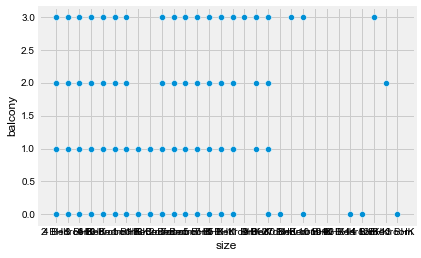

In [1377]:
sns.scatterplot(x=df['size'], y=df.balcony)

In [1378]:
df[df['balcony'].isna()]

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
6,6,Super built-up Area,0,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,7,Super built-up Area,1,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
9,9,Plot Area,1,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00
34,34,Built-up Area,1,Kasturi Nagar,3 BHK,Kantsce,1925,3.0,NaN,125.00
40,40,Built-up Area,1,Murugeshpalya,2 BHK,Gentson,1296,2.0,NaN,81.00
...,...,...,...,...,...,...,...,...,...,...
10560,10560,Built-up Area,1,HSR Layout,5 Bedroom,NaN,4200,5.0,NaN,245.00
10561,10561,Super built-up Area,1,Thubarahalli,3 BHK,Asnts a,1540,3.0,NaN,90.00
10593,10593,Built-up Area,1,Marathahalli,4 Bedroom,Vemes H,3090,4.0,NaN,350.00
10634,10634,Plot Area,0,Rajankunte,NaN,NaN,1575,NaN,NaN,31.11


In [1379]:
# Dropping the ID column for its redundancy
# Getting rid of society to avoid imputing huge amount of null values
# Availability doesnt much determine the price of a house
df.drop(columns=["ID", "society"], axis=1, inplace=True)

In [1380]:
df.isna().sum()

area_type         0
availability      0
location          1
size             14
total_sqft        0
bath             65
balcony         504
price             0
dtype: int64

In [1381]:
df['location'].value_counts()

Whitefield                        433
Sarjapur  Road                    303
Electronic City                   234
Kanakpura Road                    217
Thanisandra                       178
                                 ... 
Banashankari3rd stage bigbazar      1
Vijaya Bank Colony                  1
ITI Employees Layout                1
Junnasandra                         1
 Anekal                             1
Name: location, Length: 1197, dtype: int64

In [1382]:
# Replacing 1 NaN in location with mode of the dataset
df['location'] = df['location'].fillna('Whitefield')

In [1383]:
# Replacing Size with highest occuring categorical value
df['size'].value_counts()

2 BHK         4146
3 BHK         3425
4 Bedroom      659
4 BHK          478
3 Bedroom      446
1 BHK          435
2 Bedroom      281
5 Bedroom      232
6 Bedroom      154
1 Bedroom       88
7 Bedroom       65
8 Bedroom       65
5 BHK           50
9 Bedroom       41
6 BHK           21
1 RK            13
7 BHK           12
10 Bedroom       8
9 BHK            7
8 BHK            3
11 BHK           2
10 BHK           2
11 Bedroom       2
14 BHK           1
27 BHK           1
19 BHK           1
43 Bedroom       1
12 Bedroom       1
16 BHK           1
13 BHK           1
Name: size, dtype: int64

In [1384]:
df['size'] = df['size'].fillna('2 BHK')

# Creating 3 additional columns
df['hall'] = np.nan
df['kitchen'] = np.nan
df['room_count'] = np.nan

In [1385]:
# We are splitting the values in size into 3 columns:  Hall | Kitchen | Room_Count
# This is important as 1RK is different from 1 BHK


def split_size(df, index, size):
    df.loc[index, 'room_count'] = str(size).split()[0]
    if str(size).split()[1] == "BHK":
        df.loc[index, 'hall'] = 1
        df.loc[index, 'kitchen'] = 1
    elif str(size).split()[1] == "RK":
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 1
    else:
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 0
    

# get_room_count = lambda x: int(str(x).split()[0]) if isinstance(x,str) else x

In [1386]:
for index, row in df.iterrows():
    split_size(df, index, df.loc[index, 'size'])

df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,hall,kitchen,room_count
0,Super built-up Area,0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,1.0,1.0,2
1,Plot Area,1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,0.0,0.0,4
2,Built-up Area,1,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,1.0,1.0,3
3,Super built-up Area,1,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,1.0,1.0,3
4,Super built-up Area,1,Kothanur,2 BHK,1200,2.0,1.0,51.00,1.0,1.0,2


In [1387]:
df['bath'].median()

2.0

In [1388]:
median_bath_df = pd.DataFrame(df.groupby('size')['bath'].median())
median_bath_df

,bath
size,
1 BHK,1.0
1 Bedroom,1.0
1 RK,1.0
10 BHK,12.0
10 Bedroom,10.0
11 BHK,10.5
11 Bedroom,8.5
12 Bedroom,6.0
13 BHK,13.0


In [1389]:
# Filling the NaN values in bath with corresponding median for the respective room size
for index, row in df.iterrows():
    if np.isnan(df.loc[index, 'bath']):
        df.loc[index, 'bath'] = median_bath_df.loc[df.loc[index,'size']].values[0]

In [1390]:
# Replacing all the NaN values in balcony witht the median of the subgroup based on number of rooms
balcony_df = pd.DataFrame(df.groupby('size')['balcony'].median())
balcony_df

,balcony
size,
1 BHK,1.0
1 Bedroom,0.0
1 RK,0.0
10 BHK,NaN
10 Bedroom,3.0
11 BHK,3.0
11 Bedroom,1.5
12 Bedroom,2.0
13 BHK,0.0


In [1391]:
# We can see that for properties with higher the bedroom size dont have bath. And most of our NaN are for bedrooms
# > 10. Setting all NaN as 0
balcony_df.fillna(0, inplace=True)

In [1392]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df.iterrows():
    if np.isnan(df.loc[index, 'balcony']):
        df.loc[index, 'balcony'] = balcony_df.loc[df.loc[index,'size']].values[0]
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,hall,kitchen,room_count
0,Super built-up Area,0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,1.0,1.0,2
1,Plot Area,1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,0.0,0.0,4
2,Built-up Area,1,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,1.0,1.0,3
3,Super built-up Area,1,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,1.0,1.0,3
4,Super built-up Area,1,Kothanur,2 BHK,1200,2.0,1.0,51.00,1.0,1.0,2


In [1393]:
df.isna().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
hall            0
kitchen         0
room_count      0
dtype: int64

In [1394]:
df.dropna(inplace=True)
df.isna().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
hall            0
kitchen         0
room_count      0
dtype: int64

In [1395]:
df.shape

(10656, 11)

In [1329]:
df['size'].value_counts()

2     4441
3     3871
4     1137
1      536
5      282
6      175
7       77
8       68
9       48
10      10
11       4
27       1
43       1
12       1
13       1
14       1
Name: size, dtype: int64

In [1396]:
# Finding all the rows in total_sqft which contain different units
df['total_sqft_is_alphanumeric'] = list(map(lambda x: re.search(r'[a-zA-Z]',x) != None, df['total_sqft']))
df.loc[df['total_sqft_is_alphanumeric']==True].head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,hall,kitchen,room_count,total_sqft_is_alphanumeric
410,Super built-up Area,1,Kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.5,1.0,1.0,1,True
648,Built-up Area,1,Arekere,9 Bedroom,4125Perch,9.0,2.0,265.0,0.0,0.0,9,True
775,Built-up Area,1,Basavanagara,1 BHK,1000Sq. Meter,2.0,1.0,93.0,1.0,1.0,1,True
872,Super built-up Area,1,Singapura Village,2 BHK,1100Sq. Yards,2.0,1.0,45.0,1.0,1.0,2,True
1019,Plot Area,0,Marathi Layout,1 Bedroom,5.31Acres,1.0,0.0,110.0,0.0,0.0,1,True


We can see that there are multiple units which are used here:
SqMeter/Acres/SqYards/Grounds/Cents/Guntha/Perch

Using calculators from https://housing.com/calculators/ground-to-square-feet
* 1 Ground =  2400.352024 sq.ft
* 1 Perch = 272.25 sq.ft
* 1 acre = 43560.00001 sq.ft
* 1 Guntha = 1089 sq.ft
* 1 sq.yards = 9.000000878 sq.ft
* 1 sq.meters = 10.76391042 sq.ft
* 1 Cents = 435.56 sq.ft

In [1397]:
def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)

df["total_sqft"] = df["total_sqft"].apply(units_in_sq_ft)

In [1398]:
df.drop(columns=["total_sqft_is_alphanumeric"], inplace=True)

In [1409]:
df.room_count.value_counts()

2     4441
3     3871
4     1137
1      536
5      282
6      175
7       77
8       68
9       48
10      10
11       4
14       1
12       1
16       1
43       1
27       1
19       1
13       1
Name: room_count, dtype: int64

In [1421]:
df[['total_sqft','price','room_count']] = df[['total_sqft','price','room_count']].astype(float)


total_sqft
1100.0 1680.0
price
50.0 120.0
room_count
2.0 3.0


<AxesSubplot:>

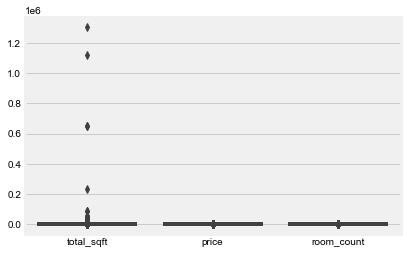

In [1427]:
# Getting rid of the outliers from originally numeric column
df_o = df[['total_sqft','price','room_count']]
for col in df_o.columns:
    tempdata = df_o.sort_values(by=col)[col]
    print(col)
    q1,q3 = tempdata.quantile([0.25,0.75])
    print(q1,q3)
    IQR = q1-q3
    lr = q1-1.5*IQR
    ur = q3+1.5*IQR
    # Replacing the values 
    df_o[col].apply(lambda x: x if x <= ur else ur)
    df_o[col].apply(lambda x: x if x >= lr else lr)

sns.boxplot(data=df_o)

In [1428]:
df_o.head()

,total_sqft,price,room_count
0,1056.0,39.07,2.0
1,2600.0,120.00,4.0
2,1440.0,62.00,3.0
3,1521.0,95.00,3.0
4,1200.0,51.00,2.0


In [ ]:
df.drop(columns=['total_sqft','price','room_count'], inplace=True)
df.con

### Adding per square-feet price

In [1333]:
df['price_per_square_ft'] = (df['price']*1000000)/df['total_sqft']
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,0,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,36998.106061
1,Plot Area,1,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,46153.846154
2,Built-up Area,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,43055.555556
3,Super built-up Area,1,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,62458.908613
4,Super built-up Area,1,Kothanur,2,1200.0,2.0,1.0,51.00,42500.000000


### Finding all the unique Locations

In [1334]:
# Removing all the rows where the room-size are lesser that even 300 sq.ft
df_1 = df[~(df['total_sqft']/df['size'] < 300)]
df_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,0,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,36998.106061
1,Plot Area,1,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,46153.846154
2,Built-up Area,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,43055.555556
3,Super built-up Area,1,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,62458.908613
4,Super built-up Area,1,Kothanur,2,1200.0,2.0,1.0,51.00,42500.000000


In [1335]:
df_1.shape

(10051, 9)

In [1336]:
# Erasing the outliers from each group of locations
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_ft)
        st=np.std(subdf.price_per_square_ft)
        reduced_df=subdf[(subdf.price_per_square_ft>(m-3*st))& (subdf.price_per_square_ft<(m+3*st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df_2=remove_pps_outliers(df_1)
df_2.shape

(9519, 9)

Text(0, 0.5, 'Count')

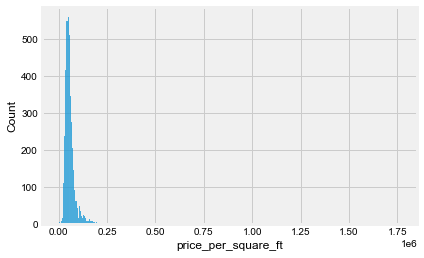

In [1337]:
sns.histplot(df_2['price_per_square_ft'])
plt.ylabel('Count')

Text(0, 0.5, 'Count')

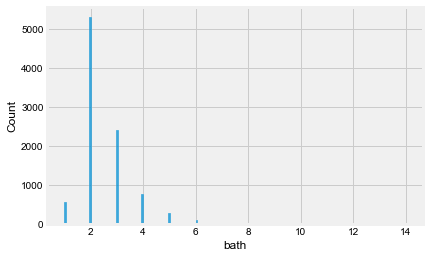

In [1338]:
sns.histplot(df_2['bath'])
plt.ylabel('Count')

In [1339]:
df_2.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,1,Devarabeesana Halli,2,1100.0,2.0,1.0,70.0,63636.363636
1,Super built-up Area,1,Devarabeesana Halli,3,1672.0,3.0,2.0,150.0,89712.918660
2,Built-up Area,1,Devarabeesana Halli,3,1750.0,3.0,3.0,149.0,85142.857143
3,Super built-up Area,1,Devarabeesana Halli,3,1670.0,3.0,2.0,160.0,95808.383234
4,Super built-up Area,1,Devarabeesana Halli,3,1750.0,3.0,2.0,150.0,85714.285714


## CHECKING FOR OUTLIERS

<AxesSubplot:xlabel='price'>

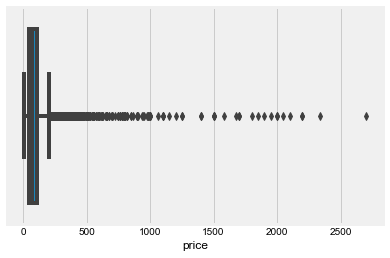

In [1340]:
# First checking the target column
sns.boxplot(df_2['price'])

We are keeping the outliers for price, as we might be needed to predict such cases in Test Data

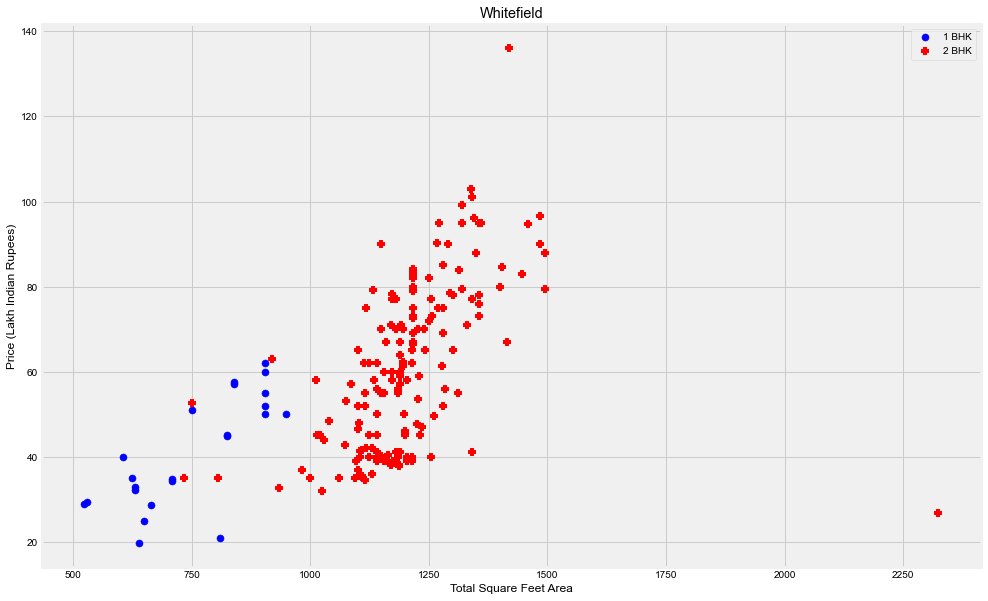

In [1341]:
def plot_multiple_size_with_price(size_1, size_2, location, df):
    bhk_first = df[(df['location']==location) & (df['size']==size_1)]
    bhk_second = df[(df['location']==location) & (df['size']==size_2)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk_first.total_sqft,bhk_first.price,color='blue',label=str(size_1)+" BHK", s=50)
    plt.scatter(bhk_second.total_sqft,bhk_second.price,marker='+',color='red',label=str(size_2)+" BHK", s=50)
    
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_multiple_size_with_price(1,2, "Whitefield", df_2)

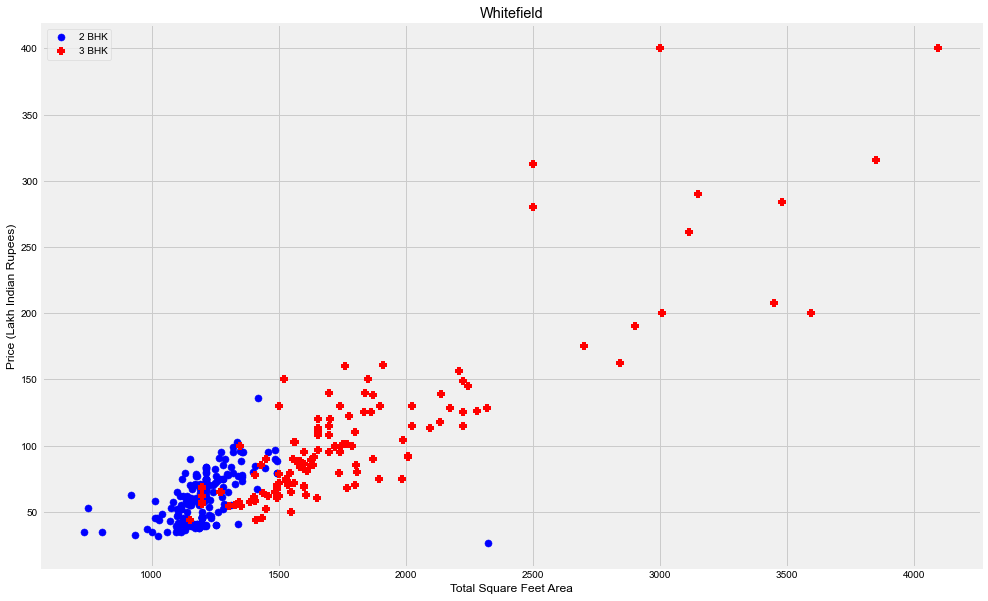

In [1342]:
plot_multiple_size_with_price(2,3, "Whitefield", df_2)

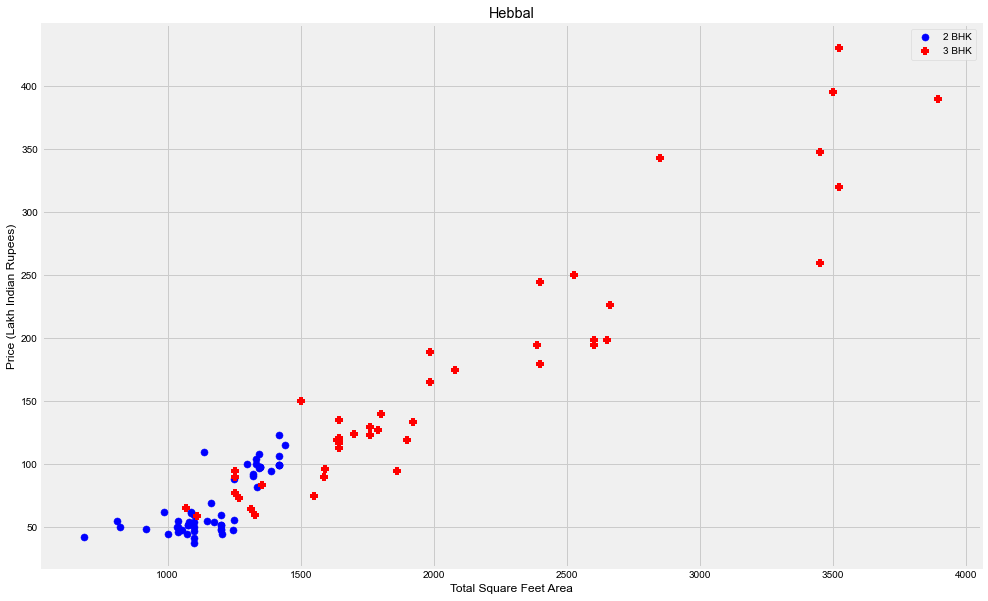

In [1343]:
plot_multiple_size_with_price(2,3, "Hebbal", df_2)

In a location, when the square feet increases as well as the number of rooms increase, still certain houses with lower space and room number are priced higher than larger houses. Those rows need to be removed. We will find the mean price of a house of a particular size. And if the per square foot rate of the house is less than mean of smaller size house, then we will get rid of it.

In [1344]:
def remove_irregularly_priced_houses(df):
    exclusion_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for size, size_df in location_df.groupby('size'):
            bhk_stats[size] = {
                'mean': np.mean(size_df.price_per_square_ft),
                'std': np.std(size_df.price_per_square_ft),
                'count': size_df.shape[0]
            }
        for size, size_df in location_df.groupby('size'):
            stats = bhk_stats.get(size-1)
            if stats and stats['count'] > 5:
                exclusion_indices = np.append(exclusion_indices, size_df[size_df.price_per_square_ft<(stats['mean'])].index.values)
    return df.drop(exclusion_indices, axis='index')

df_3 = remove_irregularly_priced_houses(df_2)
df_3.shape

(7776, 9)

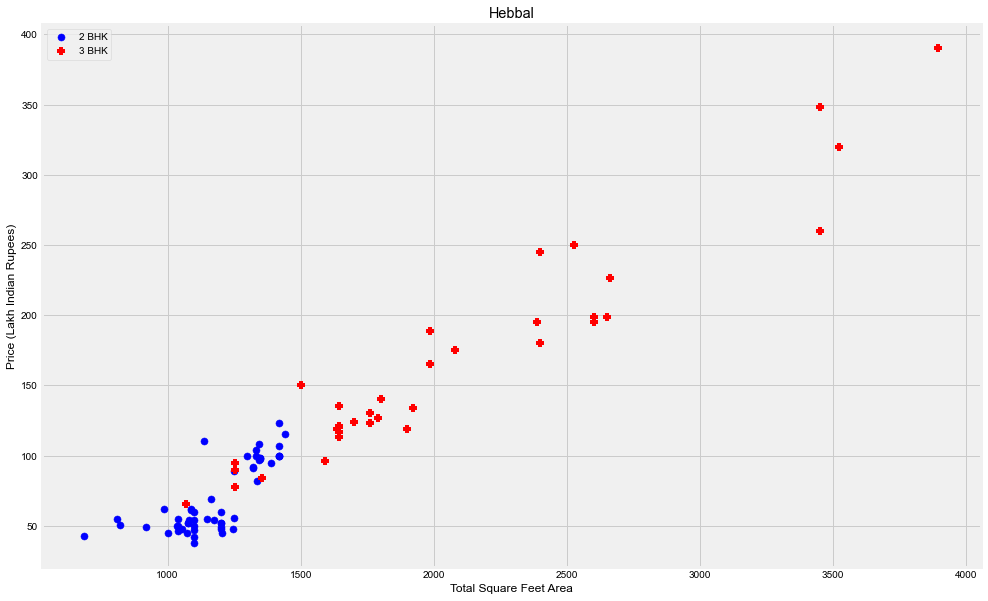

In [1193]:
plot_multiple_size_with_price(2,3, "Hebbal", df_3)

We can see that the number of 3 BHKs with lesser price-per-square-feet as compared to 2 BHK are removed.

## Doing PREPROCESSING

In [1194]:
from sklearn import preprocessing

df_2_num = df_2.select_dtypes(include=np.number)
# Dropping the future target column from Scaling
df_2_num.drop(columns=['price'], inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
df_2_num_scaled = min_max_scaler.fit_transform(df_2_num.values)
scaled_df = pd.DataFrame(df_2_num_scaled, columns=df_2_num.columns)
scaled_df.head()

,size,total_sqft,bath,balcony,price_per_square_ft
0,0.222222,0.002101,0.153846,0.666667,0.116245
1,0.222222,0.002220,0.153846,1.000000,0.110302
2,0.222222,0.002098,0.153846,0.666667,0.124173
3,0.222222,0.002220,0.153846,0.666667,0.111045
4,0.222222,0.001455,0.076923,1.000000,0.045348


In [1195]:
df_2_normalized = pd.concat([df_2.select_dtypes(exclude=np.number), scaled_df, df_2['price']], axis=1)
df_2_normalized.head()

,location,size,total_sqft,bath,balcony,price_per_square_ft,price
0,Devarabeesana Halli,0.222222,0.002101,0.153846,0.666667,0.116245,150.0
1,Devarabeesana Halli,0.222222,0.002220,0.153846,1.000000,0.110302,149.0
2,Devarabeesana Halli,0.222222,0.002098,0.153846,0.666667,0.124173,160.0
3,Devarabeesana Halli,0.222222,0.002220,0.153846,0.666667,0.111045,150.0
4,Devarachikkanahalli,0.222222,0.001455,0.076923,1.000000,0.045348,44.0


In [1196]:
df_2['location'] = df_2['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_test['location'] = df_test['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_dist['location'] = df_dist['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))

set_locations_train_data = set(df_2['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_dist = set(df_dist['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)

In [1197]:
print(len(set_locations_train_data))

701


In [1198]:
print(len(set_locations_test_data))

669


In [1199]:
print(len(set_location_in_both_train_test_data))

479


In order to have the same number of columns in both train and test data, we need to set any location which is not present in both train and test data as other

In [1200]:
# Setting the location which are in train as well as in test and setting the other locations as other
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

print(f"{len(df_2_normalized['location'].unique())}")

480


In [1201]:
df_2.head()

,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,devarabeesana halli,3,1672.0,3.0,2.0,150.0,89712.918660
1,devarabeesana halli,3,1750.0,3.0,3.0,149.0,85142.857143
2,devarabeesana halli,3,1670.0,3.0,2.0,160.0,95808.383234
3,devarabeesana halli,3,1750.0,3.0,2.0,150.0,85714.285714
4,devarachikkanahalli,3,1250.0,2.0,3.0,44.0,35200.000000


In [1203]:
df_rent["location"] = df_rent["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_rent["location"].unique()).intersection(set_location_in_both_train_test_data))

88

Since columns whose locations are present in test-data and train data and in rent data is so less... we would never be able to use this table for analysis.

In [1204]:
df_dist["location"] = df_dist["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_dist["location"].unique()).intersection(set_location_in_both_train_test_data))

421

In [1205]:
# Setting the location distance from CITY Centre as well in df_2
df_3 = df_2_normalized.copy()

In [1206]:
df_3.head()

,location,size,total_sqft,bath,balcony,price_per_square_ft,price
0,devarabeesana halli,0.222222,0.002101,0.153846,0.666667,0.116245,150.0
1,devarabeesana halli,0.222222,0.002220,0.153846,1.000000,0.110302,149.0
2,devarabeesana halli,0.222222,0.002098,0.153846,0.666667,0.124173,160.0
3,devarabeesana halli,0.222222,0.002220,0.153846,0.666667,0.111045,150.0
4,devarachikkanahalli,0.222222,0.001455,0.076923,1.000000,0.045348,44.0


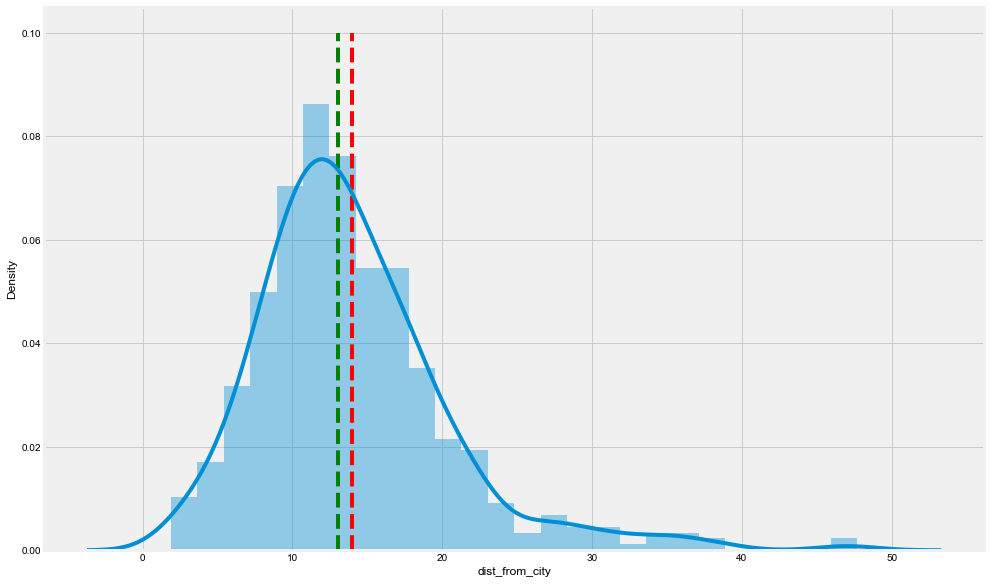

In [1207]:
sns.distplot(df_dist['dist_from_city'], kde=True)
plt.vlines(x=df_dist['dist_from_city'].mean(), ymin=0, ymax=0.1, colors='r', linestyles='dashed')
plt.vlines(x=df_dist['dist_from_city'].median(), ymin=0, ymax=0.1, colors='g', linestyles='dashed')

In [1208]:
df_3.isna().sum()

location               0
size                   0
total_sqft             0
bath                   0
balcony                0
price_per_square_ft    0
price                  0
dtype: int64

In [1209]:
df_3.dropna()

,location,size,total_sqft,bath,balcony,price_per_square_ft,price
0,devarabeesana halli,0.222222,0.002101,0.153846,0.666667,0.116245,150.00
1,devarabeesana halli,0.222222,0.002220,0.153846,1.000000,0.110302,149.00
2,devarabeesana halli,0.222222,0.002098,0.153846,0.666667,0.124173,160.00
3,devarabeesana halli,0.222222,0.002220,0.153846,0.666667,0.111045,150.00
4,devarachikkanahalli,0.222222,0.001455,0.076923,1.000000,0.045348,44.00
...,...,...,...,...,...,...,...
8774,other,0.222222,0.002266,0.153846,0.333333,0.061549,84.83
8775,other,0.111111,0.001565,0.076923,0.333333,0.060553,61.99
8776,other,0.111111,0.000888,0.076923,0.333333,0.070508,48.00
8777,other,0.111111,0.001072,0.076923,0.333333,0.071099,55.00


In [1067]:
def min_max_scale(x, min_val, max_val):
    return (x - min_val)/(max_val - min_val)


In [1210]:
# Optimizing number of features in OLS model
from itertools import combinations

X_num = df_3.select_dtypes(include=np.number)
X_num.drop(columns=["price", "price_per_square_ft"], inplace=True)
out = df_3["price"]

column_list = X_num.columns
interactions = list(combinations(column_list, 1))

interaction_dict = {}
for interaction in interactions:
    print(interaction)
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

('size',)
('total_sqft',)
('bath',)
('balcony',)
0.3104557061079295 ('balcony',)


Index(['size', 'total_sqft', 'bath', 'balcony'], dtype='object')

In [1211]:
# Optimizing number of features in OLS model
from itertools import combinations

X_num = df_3.select_dtypes(include=np.number)
X_num.drop(columns=["price", "price_per_square_ft"], inplace=True)
out = df_3["price"]

column_list = X_num.columns
interactions = list(combinations(column_list, 2))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.4993052223782195 ('total_sqft', 'balcony')
0.38714084087035283 ('total_sqft', 'bath')
0.3820194850269335 ('size', 'total_sqft')
0.31989103744804037 ('bath', 'balcony')
0.3187229576589541 ('size', 'balcony')


Index(['size', 'total_sqft', 'bath', 'balcony'], dtype='object')

In [1212]:
# Optimizing number of features in OLS model
from itertools import combinations

X_num = df_3.select_dtypes(include=np.number)
X_num.drop(columns=["price", "price_per_square_ft"], inplace=True)
out = df_3["price"]

column_list = X_num.columns
interactions = list(combinations(column_list, 3))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.46023353682785917 ('total_sqft', 'bath', 'balcony')
0.45951836000219093 ('size', 'total_sqft', 'balcony')
0.34426708282231433 ('size', 'total_sqft', 'bath')
0.31196470069607307 ('size', 'bath', 'balcony')


Index(['size', 'total_sqft', 'bath', 'balcony'], dtype='object')

In [1213]:
df_3.isna().sum()

location               0
size                   0
total_sqft             0
bath                   0
balcony                0
price_per_square_ft    0
price                  0
dtype: int64

In [1214]:
# Dummy encoding for location
dummies = pd.get_dummies(data=df_3, columns=['location'])
dummies.drop(columns=['location_other'], inplace=True)
dummies.head()

,size,total_sqft,bath,balcony,price_per_square_ft,price,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.222222,0.002101,0.153846,0.666667,0.116245,150.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.222222,0.002220,0.153846,1.000000,0.110302,149.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.222222,0.002098,0.153846,0.666667,0.124173,160.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.222222,0.002220,0.153846,0.666667,0.111045,150.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.222222,0.001455,0.076923,1.000000,0.045348,44.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1215]:
df_4 = dummies.copy()
df_4.head()

,size,total_sqft,bath,balcony,price_per_square_ft,price,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.222222,0.002101,0.153846,0.666667,0.116245,150.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.222222,0.002220,0.153846,1.000000,0.110302,149.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.222222,0.002098,0.153846,0.666667,0.124173,160.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.222222,0.002220,0.153846,0.666667,0.111045,150.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.222222,0.001455,0.076923,1.000000,0.045348,44.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1216]:
X=df_4.drop(columns=['price'], axis='columns')
X.head()

,size,total_sqft,bath,balcony,price_per_square_ft,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,location_1st phase jp nagar,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.222222,0.002101,0.153846,0.666667,0.116245,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.222222,0.002220,0.153846,1.000000,0.110302,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.222222,0.002098,0.153846,0.666667,0.124173,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.222222,0.002220,0.153846,0.666667,0.111045,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.222222,0.001455,0.076923,1.000000,0.045348,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1217]:
y = df_4['price']

In [1218]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

model_1=LinearRegression()
model_1.fit(X_train,y_train)
model_1.score(X_test,y_test)

-6.529415829690514e+21

In [1219]:
model_1.predict(X)

array([153.17084483, 145.18170435, 165.44154593, ...,  62.28099155,
        63.29628514,  82.86931226])

In [1220]:
y

0       150.00
1       149.00
2       160.00
3       150.00
4        44.00
         ...  
8774     84.83
8775     61.99
8776     48.00
8777     55.00
8778     78.00
Name: price, Length: 8779, dtype: float64

In [1221]:
rmse(model_1.predict(X), y)

4160613375450.3696

#### Dropping the price_per_square_feet column

In [1222]:
X_1 = X.drop(columns=["price_per_square_ft"])
X_1.shape

(8779, 483)

In [1223]:
X_train,X_test,y_train,y_test=train_test_split(X_1,y,test_size=0.2)

model_3=LinearRegression()
model_3.fit(X_train,y_train)
model_3.score(X_test,y_test)

-1.8145244084376389e+22

In [1227]:


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=25)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        y_pred=gs.predict(X)
        gs_rmse = rmse(y,y_pred)
        scores.append({
            'model': algo_name,
            'shape': X.shape,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
            'rmse': gs_rmse
        })

    return pd.DataFrame(scores,columns=['model','shape', 'best_score','best_params','rmse'])

find_best_model_using_gridsearchcv(X_1,y)


,model,shape,best_score,best_params,rmse
0,linear_regression,"(8779, 483)",-4.061036e+23,{'normalize': False},75.738358
1,lasso,"(8779, 483)",3.089086e-01,"{'alpha': 1, 'selection': 'cyclic'}",95.450130
2,decision_tree,"(8779, 483)",4.388455e-01,"{'criterion': 'mse', 'splitter': 'random'}",7.134933


In [1228]:
X_1.shape

(8779, 483)

In [1229]:
res_df = pd.DataFrame(columns=['model','best_score','best_params','rmse'])
# Creating the best model separately

cv = ShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
gs =  GridSearchCV(
    DecisionTreeRegressor(), 
    {
        'criterion' : ['mse','friedman_mse'],
        'splitter': ['best','random']
    },
    cv=cv, 
    return_train_score=False
)
gs.fit(X_1,y)

y_pred=gs.predict(X_1)
gs_rmse = rmse(y,y_pred)
res_df.append({
    "model": "DecisionTreeRegressor",
    "best_score": gs.best_score_,
    "best_params": gs.best_params_,
    "rmse": gs_rmse
}, ignore_index=True)

,model,best_score,best_params,rmse
0,DecisionTreeRegressor,0.537517,"{'criterion': 'friedman_mse', 'splitter': 'best'}",7.134933


In [1230]:
# Trying Grid Search CV with ElasticNet
hyp_param = {'alpha':[0.18, 0.19, 0.2, 0.21], 'l1_ratio':[0.90,0.95, 0.98]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

enet_model = hyper_model.fit(X_1, y)
print(f"Best Hyper Parameter: {enet_model.best_params_}")
print(f"Best Score: {enet_model.best_score_}")

Best Hyper Parameter: {'alpha': 0.21, 'l1_ratio': 0.98}
Best Score: 0.007387587369492188


In [1231]:
enet_rmse = rmse(enet_model.predict(X_1),y)
enet_rmse

113.31506580680062

In [1233]:
from sklearn.ensemble import RandomForestRegressor

x_train,x_test,y_train,y_test=train_test_split(X_1,y, test_size=0.1)
RFC = RandomForestRegressor(n_estimators=75, n_jobs=-1, oob_score=True, random_state=10)
RFC.fit(x_train,y_train)
y_test_pred = RFC.predict(x_test)
rmse(y_test, y_test_pred)

51.351533580978604

In [1234]:
from sklearn.model_selection import GridSearchCV

x=X_1

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=10)

param={'max_depth':[5,10,15,20,30],'min_samples_leaf':[10,15,20,50,100]}

gs_rfc=GridSearchCV(estimator=RFC,param_grid=param,cv=4,n_jobs=-1,scoring='r2')

gs_rfc.fit(x_train,y_train)

gs_rfc.best_estimator_
gs_best=gs_rfc.best_estimator_

gs_best.fit(x_train,y_train)

train_pred=gs_best.predict(x_train)

test_pred=gs_best.predict(x_test)


print('RMSE for train:',np.sqrt(mean_squared_error(y_train,train_pred)))
print('RMSE for test:',np.sqrt(mean_squared_error(y_test,test_pred)))


print('r2_score for train:',r2_score(y_train,train_pred))
print('r2_score for test:',r2_score(y_test,test_pred))

RMSE for train: 64.233117450204
RMSE for test: 77.26679052949432
r2_score for train: 0.6808304367585163
r2_score for test: 0.5972523187818751


In [1235]:
from sklearn.ensemble import HistGradientBoostingRegressor

est = HistGradientBoostingRegressor().fit(X_1, y)
y_pred = est.predict(X_1)
rmse_hgbr = rmse(y_pred, y)
print(est.score(X_1, y), rmse_hgbr)

0.739011552175718 58.512482756656425


## PROCESSING THE TEST-DATA

In [1236]:
df_test.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th phase jp nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,tc palaya,1 Bedroom,NaN,1350,1.0,0.0


In [1237]:
df_test_1 = df_test.drop(columns=["ID", "area_type", "availability", "society"])
df_test_1.isna().sum()

location        0
size            2
total_sqft      0
bath            8
balcony       105
dtype: int64

In [1238]:
df_test_1['size'] = df_test_1['size'].fillna('2 BHK')

In [1239]:
df_test_1['size']=df_test_1['size'].apply(get_room_count)

In [1240]:
df_test_1.head()

,location,size,total_sqft,bath,balcony
0,chamrajpet,2,650,1.0,1.0
1,7th phase jp nagar,3,1370,2.0,1.0
2,whitefield,3,1725,3.0,2.0
3,jalahalli,2,1000,2.0,0.0
4,tc palaya,1,1350,1.0,0.0


In [1241]:
df_test_1.isna().sum()

location        0
size            0
total_sqft      0
bath            8
balcony       105
dtype: int64

In [1242]:
# Filling the NaN values in bath with corresponding median for the respective room size
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'bath']):
        df_test_1.loc[index, 'bath'] = median_bath_df.loc[df_test_1.loc[index,'size']].values[0]


In [1243]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'balcony']):
        if df_test_1.loc[index,'size'] in balcony_df.index:
            df_test_1.loc[index, 'balcony'] = balcony_df.loc[df_test_1.loc[index,'size']].values[0]
        else:
            df_test_1.loc[index, 'balcony'] = 0

In [1244]:
df_test_1["total_sqft"] = df_test_1["total_sqft"].apply(units_in_sq_ft)

In [1245]:
df_test_1.isna().sum()

location      0
size          0
total_sqft    0
bath          0
balcony       0
dtype: int64

<AxesSubplot:xlabel='size', ylabel='bath'>

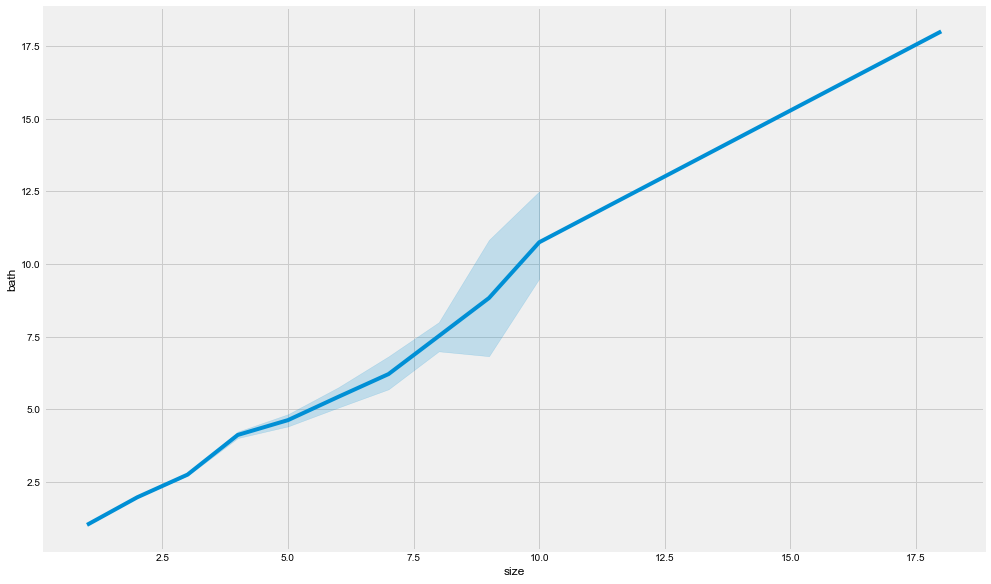

In [1246]:
sns.lineplot(x=df_test_1['size'], y=df_test_1['bath'])

In [1247]:
df_test_1.head()

,location,size,total_sqft,bath,balcony
0,chamrajpet,2,650.0,1.0,1.0
1,7th phase jp nagar,3,1370.0,2.0,1.0
2,whitefield,3,1725.0,3.0,2.0
3,jalahalli,2,1000.0,2.0,0.0
4,tc palaya,1,1350.0,1.0,0.0


In [1248]:
df_test_num = df_test_1.select_dtypes(include=np.number)
min_max_scaler = preprocessing.MinMaxScaler()
df_test_num_scaled = min_max_scaler.fit_transform(df_test_num.values)
scaled_test_df = pd.DataFrame(df_test_num_scaled, columns=df_test_num.columns)

In [1249]:
scaled_test_df.head()

,size,total_sqft,bath,balcony
0,0.058824,0.002258,0.000000,0.333333
1,0.117647,0.005013,0.058824,0.333333
2,0.117647,0.006372,0.117647,0.666667
3,0.058824,0.003597,0.058824,0.000000
4,0.000000,0.004937,0.000000,0.000000


In [1250]:
df_test_normalized = pd.concat([df_test_1.select_dtypes(exclude=np.number), scaled_test_df], axis=1)
df_test_normalized.head()

,location,size,total_sqft,bath,balcony
0,chamrajpet,0.058824,0.002258,0.000000,0.333333
1,7th phase jp nagar,0.117647,0.005013,0.058824,0.333333
2,whitefield,0.117647,0.006372,0.117647,0.666667
3,jalahalli,0.058824,0.003597,0.058824,0.000000
4,tc palaya,0.000000,0.004937,0.000000,0.000000


In [1251]:
df_test_normalized['location'] = df_test_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

In [1252]:
len(df_test_normalized['location'].unique())

480

In [1253]:
df_test_normalized.isna().sum()

location      0
size          0
total_sqft    0
bath          0
balcony       0
dtype: int64

In [1254]:
dummies = pd.get_dummies(data=df_test_normalized, columns=['location'])
dummies.drop(columns=['location_other'], inplace=True)

dummies.head()

,size,total_sqft,bath,balcony,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,location_1st phase jp nagar,location_1st stage indira nagar,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.058824,0.002258,0.000000,0.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.117647,0.005013,0.058824,0.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.117647,0.006372,0.117647,0.666667,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.058824,0.003597,0.058824,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.004937,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1255]:
df_test_2 = dummies.copy()
df_test_2.head()

,size,total_sqft,bath,balcony,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,location_1st phase jp nagar,location_1st stage indira nagar,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.058824,0.002258,0.000000,0.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.117647,0.005013,0.058824,0.333333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.117647,0.006372,0.117647,0.666667,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.058824,0.003597,0.058824,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.004937,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1256]:
df_test_2.shape

(2664, 483)

In [1257]:
y_test_pred = gs.predict(df_test_2)
y_test_pred

array([116.  , 230.  , 901.  , ...,  60.  ,  93.  , 159.75])

In [1258]:
df_sol = pd.DataFrame()
df_sol['price'] = y_test_pred
df_sol.index.name='ID'
df_sol.head()

,price
ID,
0,116.0
1,230.0
2,901.0
3,260.0
4,138.0


In [1259]:
df_sol.to_csv("sol_gs.csv")

### Using Elastic Regression Model

In [1260]:
y_pred_enet = enet_model.predict(df_test_2)
y_pred_enet

array([94.95514948, 96.4220652 , 97.29830754, ..., 95.83139182,
       98.76522327, 94.36447609])

In [1261]:
df_sol_enet = pd.DataFrame()
df_sol_enet['price'] = y_pred_enet
df_sol_enet.index.name='ID'
df_sol_enet.head()

,price
ID,
0,94.955149
1,96.422065
2,97.298308
3,95.831392
4,94.364476


In [1262]:
df_sol_enet.to_csv("sol_enet.csv")

### Using Random Forest

In [1263]:
y_pred_RFC = RFC.predict(df_test_2)
df_sol_RFC = pd.DataFrame()
df_sol_RFC['price'] = y_pred_enet
df_sol_RFC.index.name='ID'
df_sol_RFC.to_csv("sol_RFC.csv")

### Using GridSearch CV on Random Forest

In [1264]:
y_pred_GS_CV = gs_best.predict(df_test_2)
df_sol_GS_CV = pd.DataFrame()
df_sol_GS_CV['price'] = y_pred_GS_CV
df_sol_GS_CV.index.name='ID'
df_sol_GS_CV.to_csv("sol_GS_CV.csv")

In [1265]:
y_pred_hgbr = est.predict(df_test_2)
df_sol_hgbr = pd.DataFrame()
df_sol_hgbr['price'] = y_pred_hgbr
df_sol_hgbr.index.name='ID'
df_sol_hgbr.to_csv("sol_HGBR.csv")